# Using classification models to determine whether a transaction is fraudulent

## 1. Problem definition

In the classification framework defined for this case study, the response (or target) variable has the column "Class". This column has a value of 1 in the case of fraud and a value of 0 otherwise.

The dataset used is obtained from Kaggle(https://oreil.ly/CeFRs). This dataset holds transactions by European cardholders that occured over two days in September 2013, with 492 cases of fraud out of 284,807 transactions.

The dataset has been anonymized for privacy reasons. Given that certain feature names are not provided (i.e., they are called V1, V2, V3, etc.), the visualization and feature importance will not give much insight into the behavior of the model.

By the end of this case study, readers will be familiar with a general approach to fraud modeling, from gathering and cleaning data to building and tuning a classifier.

## 2. Getting started---loading the data and Python packages

### 2.1. Loading the Python packages.

The list of the libraries used for data loading, data analysis, data preparation, model evaluation, and model tuning are shown below. The packages used for different purposes have been separated in the Python code below.





Packages for data loading, data analysis, and data preparation

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot

from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler

Packages for model evaluation and classification models

In [60]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Packages for deep learning models

In [61]:
#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

Packages for saving the model 

In [62]:
from pickle import dump
from pickle import load

In [63]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

## 3. Exploratory data analysis

The following sections walk through some high-level data inspection.

### 3.1. Descriptive analytics

The first thing we must do is gather a basic sense of our data. Remember, except for the transaction and amount, we do not know the names of other columns. The only thing we know is that the values of those columns have been scaled. Let's look at the shape and columns of the data : 

In [64]:
import os
import sys
sys.path.append('/Users/damienmellot/desktop/MLE/Projects/fml/fraud-detection/data')

In [65]:
dataset = read_csv('creditcard_sample.csv')

In [66]:
# shape
dataset.shape

(99999, 31)

In [67]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

Time     V1     V2     V3     V4     V5     V6     V7     V8     V9  ...    V21    V22    V23  \
0     0 -1.360 -0.073  2.536  1.378 -0.338  0.462  0.240  0.099  0.364  ... -0.018  0.278 -0.110   
1     0  1.192  0.266  0.166  0.448  0.060 -0.082 -0.079  0.085 -0.255  ... -0.226 -0.639  0.101   
2     1 -1.358 -1.340  1.773  0.380 -0.503  1.800  0.791  0.248 -1.515  ...  0.248  0.772  0.909   
3     1 -0.966 -0.185  1.793 -0.863 -0.010  1.247  0.238  0.377 -1.387  ... -0.108  0.005 -0.190   
4     2 -1.158  0.878  1.549  0.403 -0.407  0.096  0.593 -0.271  0.818  ... -0.009  0.798 -0.137   

     V24    V25    V26    V27    V28  Amount  Class  
0  0.067  0.129 -0.189  0.134 -0.021  149.62      0  
1 -0.340  0.167  0.126 -0.009  0.015    2.69      0  
2 -0.689 -0.328 -0.139 -0.055 -0.060  378.66      0  
3 -1.176  0.647 -0.222  0.063  0.061  123.50      0  
4  0.141 -0.206  0.502  0.219  0.215   69.99      0  

[5 rows x 31 columns]

In [68]:
# types
set_option('display.max_rows', 500)
dataset.dtypes

Time        int64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [69]:
# describe data
set_option('precision', 3)
dataset.describe()

Time         V1         V2         V3         V4         V5         V6         V7  \
count  99999.000  99999.000  99999.000  99999.000  99999.000  99999.000  99999.000  99999.000   
mean   42432.982     -0.262     -0.032      0.676      0.163     -0.279      0.094     -0.109   
std    17044.825      1.859      1.657      1.323      1.349      1.356      1.301      1.211   
min        0.000    -56.408    -72.716    -33.681     -5.173    -42.148    -26.161    -31.765   
25%    33471.500     -1.028     -0.599      0.177     -0.711     -0.899     -0.648     -0.600   
50%    44299.000     -0.261      0.078      0.754      0.193     -0.314     -0.157     -0.069   
75%    55851.000      1.153      0.736      1.376      1.032      0.250      0.486      0.415   
max    67374.000      1.960     18.902      4.226     16.716     34.802     22.529     36.677   

              V8         V9  ...        V21        V22        V23        V24        V25  \
count  99999.000  99999.000  ...  99999.000  99999.000  99999.000  99999.000  99999.000   
mean       0.056     -0.047  ...     -0.031     -0.109     -0.037      0.009      0.132   
std        1.208      1.121  ...      0.719      0.634      0.633      0.595      0.441   
min      -73.217     -9.284  ...    -34.830    -10.933    -44.808     -2.837    -10.295   
25%       -0.137     -0.699  ...     -0.225     -0.531     -0.176     -0.324     -0.132   
50%        0.074     -0.119  ...     -0.058     -0.084     -0.049      0.065      0.170   
75%        0.361      0.558  ...      0.119      0.308      0.082      0.406      0.420   
max       20.007     10.393  ...     22.615     10.503     19.003      4.014      5.542   

             V26        V27        V28     Amount      Class  
count  99999.000  1.000e+05  99999.000  99999.000  99999.000  
mean       0.027  6.058e-04      0.002     97.962      0.002  
std        0.495  3.937e-01      0.325    264.624      0.047  
min       -2.534 -9.391e+00     -9.618      0.000      0.000  
25%       -0.325 -6.253e-02     -0.005      7.570      0.000  
50%       -0.070  9.832e-03      0.023     26.310      0.000  
75%        0.301  8.302e-02      0.077     89.000      0.000  
max        3.517  1.215e+01     33.848  19656.530      1.000  

[8 rows x 31 columns]

As shown, the variable names are nondescript (V1, V2, etc.). Also, the data type for the entire dataset is float, except Class, which is of type interger.

How many are fraud and how many are not fraud? Let us check :

In [70]:
class_names = {0:'Not Fraud', 1:'Fraud'}
print(dataset.Class.value_counts().rename(index = class_names))

Not Fraud    99776
Fraud          223
Name: Class, dtype: int64


Notice the stark imbalance of the data labels. Most of the transactions are nonfraud. If we use this dataset as the base for our modeling, most models will not place enough emphasis on the fraud insights; the nonfraud data points will drown out any weight the fraud signal provide. As is, we may encounter difficulties modeling the prediction of fraud, with this imbalance leading the models to simply assume *all* transactions are nonfraud. This would be an unacceptable results. We will explore some ways of dealing with this issue in the subsequent sections.  

### 3.2. Data Visualization

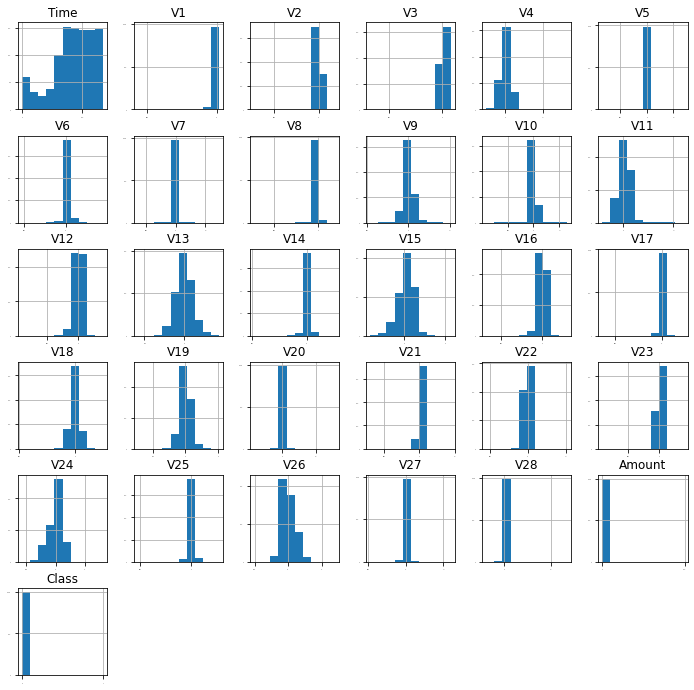

In [71]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

Distribution of most of the variables are highly skewed. However, given the variable names aren't known, we don't get much intuition from the plot.


## 4. Data Preparation

This data is from Kaggle and is already in a cleaned format without any empty rows of columns. Data cleaning or categorization is unnecessary.

### 4.1 Data Cleaning

In [72]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


### 4.2. Feature Selection

In [73]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest( k=10)
bestfeatures
Y= dataset["Class"]
X = dataset.loc[:, dataset.columns != 'Class']
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

   Specs      Score
17   V17  20657.815
14   V14  16227.609
3     V3  10383.969
12   V12   9644.180
10   V10   7909.706
16   V16   6829.653
7     V7   6157.564
11   V11   3567.597
4     V4   2840.800
18   V18   2632.037


Although some of the features are relevant, feature selection is not given significant preference


## 5. Evaluate Algorithms and Models

Now we are ready to split the data and evaluate the models.

### 5.1. Train Test Split and Evaluation Metrics

It is a good idea to partition the original dataset into training and test sets. The test set is a sample of that data that we hold back from our analysis and modeling. We use it at the end of our project to confirm the accuracy of our final model. It is the final test that gives us confidence in our estimates of accuracy on unseen data. We will use 80% of the dataset for our model training and 20% for testing :

In [74]:
# split out validation dataset for the end
Y = dataset["Class"]
X = dataset.loc[:, dataset.columns != 'Class']
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)
scoring = 'accuracy'

### 5.2. Checking Models and Algorithms

In this step, we will evaluate different machine learning models. To optimize the various hyperparameters of the models, we use ten-fold cross validation and recalculate the results ten times to account for the inherent randomness in some of the models and the CV process. 

Let us design our test harness. We will evaluate algorithms using the *accuracy metric*. This is a gross metric that will give us a quick idea of how correct a given model is. It is useful on binary classification problems.

In [75]:
# test options for classification
num_folds = 10

Let's create a baseline of performance for this problem and spot-check a number of different algorithms. The selected algorithms include :

- *Linear algorithms*

Logistic regression (LR) and linear discriminant analysis (LDA)

- *Nonlinear algorithms*

Classification and regression trees (CART) and K-nearest neighbors(KNN)

There are good reasons for selecting these models. These models are simpler and faster models with good interpretation for problems woth large datasets. CART and KNN will be able to discern any nonlinear relationships between the variables. The key problem here is using an unbalanced sample. Unless we resolve that, more complex models, such as ensemble and ANNs, will have poor prediction. We will focus on addressing this later in the case study and then will evaluate the perfomance of these tyoe models.

In [76]:
# spot check some basic Classification algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))

All the algorithms use default tuning hyperparameters. We will display the mean and standard deviation of accuracy for each algorithm as we calculate and collect the results for use later.

In [77]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.998475 (0.000512)
LDA: 0.999125 (0.000321)
KNN: 0.997925 (0.000376)
CART: 0.999162 (0.000148)


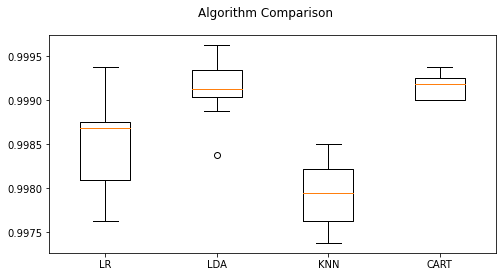

In [78]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,4)
pyplot.show()

The accuracy of the overall result is quite high. But let us check how well it predicts the fraud cases. Choosing one of the model CART from the result on the test set : 

In [79]:
# prepare model
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)

DecisionTreeClassifier()

In [80]:
# estimate accuracy on validation set

predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.999
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19946
           1       0.85      0.76      0.80        54

    accuracy                           1.00     20000
   macro avg       0.93      0.88      0.90     20000
weighted avg       1.00      1.00      1.00     20000



And producing the confusion matrix yields :

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

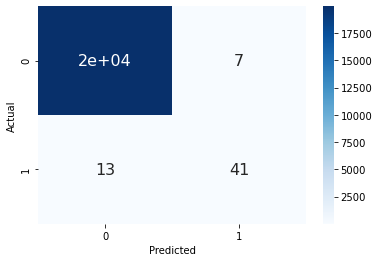

In [81]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

Overall accuracy is strong, but the confusion metrics tell a different story. Despite the high accuracy level, 11 out of 54 instances of fraud are missed and incorrectly predicted as nonfraud. The *false negative* rate is substantial.

The intention of a fraud detection model is to minimize these false negatives. To do so, the first step would be to choose the right evaluation metric.

- **Accuracy** is the number of correct predictions made as a ratio of all predictions made. 

- **Precision** is the number of items correctly identified as positive out of total items identified as positive by the model.

- **Recall** is the total number of items correctly identified as positive out of the total tue positives.


For this type of problem, we should focus on recall, the ratio of true positives to the sum of true positives and false negatives. So if false negatives are high, then the value of recall will be low.

In the next step, we perform model tuning, select the model using the recall metric, and perform undersampling.

## 6. Model Tuning

The purpose of the model tuning step is to perform the grid search on the model selected in the previous step. However, since we encountered poor model performance in the previous section due to unbalanced dataset, we will focus our attention on that. We will analyze the impact of choosing the correct evaluation metric and see the impact of using an adjusted, balanced sample.

### 6.1. Model Tuning by choosing correct evaluation metric

As mentioned in the preceding step, if false negatives are high, then the value of recall will be low.

In [82]:
scoring = 'recall'

Let us spot-check some basic classification algorithms for recall :

In [83]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))

In [84]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.529091 (0.194538)
LDA: 0.773144 (0.133709)
KNN: 0.013696 (0.028611)
CART: 0.811374 (0.077971)


We see that the LDA model has a good recall. We continue by evaluating the test set using the trained LDA :

In [85]:
# prepare model
model = LinearDiscriminantAnalysis()
model.fit(X_train, Y_train)

LinearDiscriminantAnalysis()

In [86]:
# estimate accuracy on validation set

predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))

0.9992


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

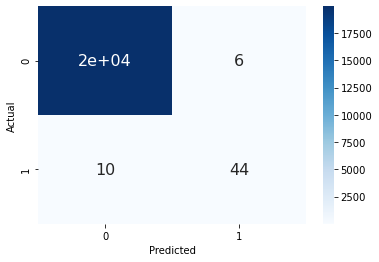

In [87]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

LDA performs better, missing only 10 out of 54 cases of fraud. Additionally, we find fewer false positives as well. However, there is still improvement to be made.

### 6.2. Model Tuning for balancing the sample by Random Under Sampling

The current data exhibits a significant class imbalance, where there are very few data points labeled "fraud". The issue of such class imbalance can result in a serious bias toward the majority class, reducing the classification performance and increasing the number of false negatives.

One of the remedies to handle such situations is to *under-sample* the data. A simple technique is to under-sample the majority class randomly and uniformly. This might lead to a loss of information, but it may yield strong results by modeling the minority class well.

Next, we will implement random under-sampling, which consists of removing data to have a more balanced dataset. This will help ensure that our models avoid overfitting.

The steps to implement random under-sampling are :

1. First, we determine the severity of the class imbalance by using value_counts() on the class column. We determine how many instances ar considered fraud transactions (*fraud=1*).

2. We bring the nonfraud transaction observation count to the same amount as the fraud transactions. Assuming we want a 50/50 ratio, this will be equivalent to 492 cases of fraud and 492 cases of nonfraud transactions.

3. We now have a subsample of our dataframe with a 50/50 ratio with regards to our classes. We train the models on this subsample. Then we perform this iteration again to shuffle the nonfraud observations in the training sample. We keep track of the model performance to wee whether our models can maintain a certain accuracy every time we repeat this process :

In [88]:
df = pd.concat([X_train, Y_train], axis=1)
# amount of fraud classes 169 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:169]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
df_new = normal_distributed_df.sample(frac=1, random_state=42)
# split out validation dataset for the end
Y_train_new= df_new["Class"]
X_train_new = df_new.loc[:, dataset.columns != 'Class']

Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


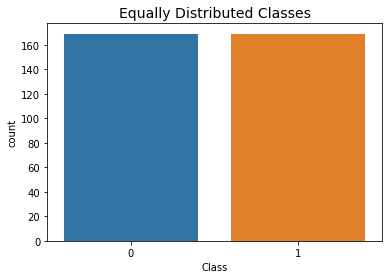

In [89]:
print('Distribution of the Classes in the subsample dataset')
print(df_new['Class'].value_counts()/len(df_new))
sns.countplot('Class', data=df_new)
pyplot.title('Equally Distributed Classes', fontsize=14)
pyplot.show()

Now that we have our dataframe correctly balanced, we can go further with our analysis and data preprocessing. Given the total number of data points are around 900, we try all the Models including Deep Learning Models. However, given the data is balanced, the metric used here is accuracy, as it focuses on both false positive and false negative.

In [90]:
scoring='accuracy'

In [91]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
# #Ensemble Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

In [92]:
# Function to create model, required for KerasClassifier
def create_model(neurons=12, activation='relu', learn_rate = 0.01, momentum=0):
    # create model
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation=activation))
    model.add(Dense(32, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model    
models.append(('DNN', KerasClassifier(build_fn=create_model, epochs=50, batch_size=10, verbose=0)))

In [93]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train_new, Y_train_new, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.952674 (0.035614)
LDA: 0.920143 (0.035203)
KNN: 0.671925 (0.077175)
CART: 0.899376 (0.040260)
NB: 0.934759 (0.032255)
SVM: 0.574064 (0.033825)
NN: 0.574242 (0.138347)
AB: 0.935027 (0.045329)
GBM: 0.940731 (0.037709)
RF: 0.952674 (0.035314)
ET: 0.958556 (0.027040)
DNN: 0.690463 (0.166343)


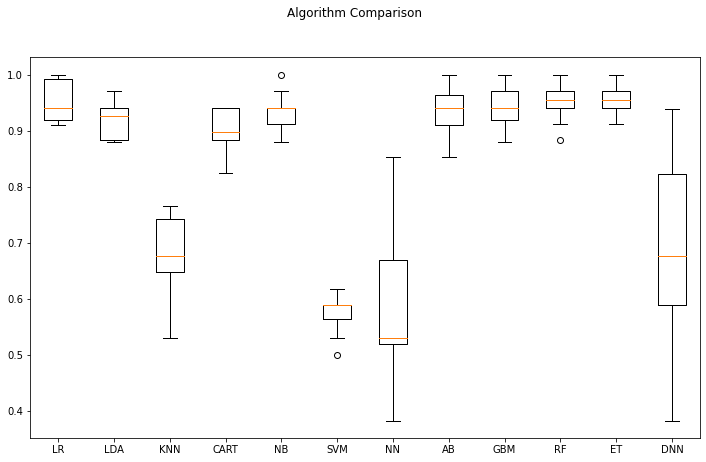

In [94]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(12,7)
pyplot.show()

Although a couple of models, including random forests (RF). and logistic resgresion (LR), perform well, GBM slightly edges out the other models. We select this for further analysis. Note that the result of the deep learning model using Keras (i.e., "DNN") is poor.

A grid search is performed for the GBM model by varying the number of estimators and maximum depth.

In [95]:
# Grid Search: GradientBoosting Tuning
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables.

''' 
n_estimators = [20,180,1000]
max_depth= [2, 3,5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
model = GradientBoostingClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train_new, Y_train_new)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.952585 using {'max_depth': 2, 'n_estimators': 1000}
#5 0.934848 (0.037176) with: {'max_depth': 2, 'n_estimators': 20}
#2 0.946613 (0.041696) with: {'max_depth': 2, 'n_estimators': 180}
#1 0.952585 (0.044600) with: {'max_depth': 2, 'n_estimators': 1000}
#6 0.922995 (0.036083) with: {'max_depth': 3, 'n_estimators': 20}
#3 0.940731 (0.037709) with: {'max_depth': 3, 'n_estimators': 180}
#4 0.937790 (0.033929) with: {'max_depth': 3, 'n_estimators': 1000}
#8 0.914082 (0.038852) with: {'max_depth': 5, 'n_estimators': 20}
#9 0.899287 (0.033800) with: {'max_depth': 5, 'n_estimators': 180}
#7 0.919964 (0.035701) with: {'max_depth': 5, 'n_estimators': 1000}


In the next step, the final model is prepared, and the result on the test set is checked :

In [96]:
# prepare model
model = GradientBoostingClassifier(max_depth= 2, n_estimators = 1000)
model.fit(X_train_new, Y_train_new)

GradientBoostingClassifier(max_depth=2, n_estimators=1000)

In [97]:
# estimate accuracy on Original validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.96175
[[19188   758]
 [    7    47]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     19946
           1       0.06      0.87      0.11        54

    accuracy                           0.96     20000
   macro avg       0.53      0.92      0.54     20000
weighted avg       1.00      0.96      0.98     20000



The accuracy of the model is high. Let's look at the confusion matrix.

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

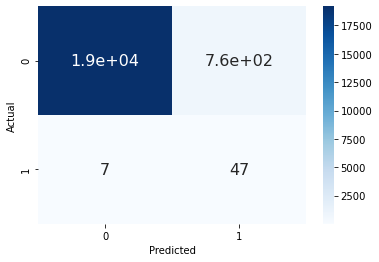

In [98]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

The results on the test set are impressive, with a high accuracy and, importantly, fewer false negatives. However, we see that an outcome of using our under-sampled data is a propensity for false positives--cases in which nonfraud transactions are misclassified as fraudulent. This is a trade-off the financial institution would have to consider. There is an inherent cost balance between the operational overhead, and possible customer experience impact, from processing false positives and the financial loss from missing cases trhough false negatives.

# Conclusion

In this case study, we performed fraud detection on credit card transactions. We illustrated how different classification machine learning models stack up against each other and demonstrated that choosing the right metric can make an important difference in model evaluation.

Under-sampling was shown to lead to a significant improvement, as most of all fraud cases in the test set were correctly identified after applying undersampling. This came with a trade-off though. The reduction in false negatives came with an increase in false positives.

Overall, by using different machine learning models, choosing the right metrics, and handling unbalanced data, we demonstrated how the implementation of a simple classification-based model can produce robust results for fraud detection.